In [2]:
import utils

2025-04-17 10:20:38.305200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 10:20:38.305254: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 10:20:38.305283: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from configs.loca_config import get_config

config = get_config()
config.batch_size = 2
config.dataset_configs.shuffle = False

## Setup Dataset

In [4]:
from scenic.train_lib import train_utils
import jax.numpy as jnp
import loca_dataset
import ops
import jax
import os

os.environ['TFDS_DATA_DIR'] = '/home/admin/john/data/tensorflow_datasets'

rng = jax.random.key(77)
data_rng, rng = jax.random.split(rng)

dataset = train_utils.get_dataset(config, data_rng)

/home/admin/anaconda3/envs/flax/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2025-04-17 10:20:42.077192: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: meta

## Load batch

In [5]:
def remove_batch_dim0(batch, debug=False):
    # Remove dim 0. (Don't know where extra dim is added at 0)
    for k, v in batch.items():
        batch[k] = v.squeeze(0)
        if debug:
            print(f"batch[{k}]: {batch[k].shape}")

    return batch

batch = next(dataset.train_iter)
print(batch.
batch = remove_batch_dim0(batch)
batch = utils.prepare_input(batch, config)

E0417 10:20:47.153566  369275 hlo_lexer.cc:443] Failed to parse int literal: 23244080047654493209


In [16]:
from configs.loca_mmearth64_small16 import SENTINEL2_L1C_MEAN, SENTINEL2_L1C_STD, SENTINEL2_L2A_MEAN, SENTINEL2_L2A_STD


rgb = batch['reference'][0][:, :, [3, 2, 1]]
batch['reference'].shape, rgb.shape

((2, 224, 224, 20), (224, 224, 3))

## Load Model

In [5]:
import flax
from flax.training import checkpoints
import optax
from scenic.train_lib import lr_schedules
import vit
import copy
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.3'

config.sen2grouped_maintain_seqlen = False
config.use_same_group_attn_mask = False

train_state = None

model = vit.ViTLOCAModel(config, dataset.meta_data)

rng, init_rng = jax.random.split(rng)
(params, _, num_trainable_params, gflops) = train_utils.initialize_model(
    model_def=model.flax_model,
    input_spec=[
        (dataset.meta_data['input_shape'], dataset.meta_data.get('input_dtype', jnp.float32))],
    config=config, rngs={'params': init_rng, 'changroup': init_rng}
)

# Only one model function but two sets of parameters.
ema_params = copy.deepcopy(params)

learning_rate_fn = lr_schedules.get_learning_rate_fn(config)
momentum_parameter_scheduler = lr_schedules.compound_lr_scheduler(
  config.momentum_rate)

weight_decay_mask = jax.tree_util.tree_map(lambda x: x.ndim != 1, params)
tx = optax.inject_hyperparams(optax.adamw)(
  learning_rate=learning_rate_fn, weight_decay=config.weight_decay,
  mask=weight_decay_mask)

opt_state = jax.jit(tx.init, backend='cpu')(params)

chrono = train_utils.Chrono()

train_state = utils.TrainState(
  global_step=0, opt_state=opt_state, tx=tx, params=params,
  ema_params=ema_params, rng=rng, metadata={'chrono': chrono.save()})

## Viz util

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you have your attention weights in a variable called 'attention_weights'
# with shape [2, 6, 980, 39]

def plot_attention_weights(attention_weights, batch_idx=0, max_tokens=100):
    """
    Plot attention weights for a specific batch.
    
    Args:
        attention_weights: JAX array with shape [batch, heads, query_len, key_len]
        batch_idx: Which batch to visualize
        max_tokens: Maximum number of tokens to display (for better visibility)
    """
    batch_attn = attention_weights[batch_idx]  # Shape: [6, 980, 39]
    num_heads = batch_attn.shape[0]
    
    # For clarity, we'll limit the number of tokens to visualize
    query_tokens = min(max_tokens, batch_attn.shape[1])
    key_tokens = min(max_tokens, batch_attn.shape[2])
    
    # Create a figure with subplots for each attention head
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for head_idx in range(num_heads):
        ax = axes[head_idx]
        # Extract attention map for this head and limit to max_tokens
        attn_map = batch_attn[head_idx, :query_tokens, :key_tokens]
        
        # Convert to numpy for plotting
        attn_map_np = jnp.array(attn_map)
        
        # Plot as heatmap
        sns.heatmap(attn_map_np, ax=ax, cmap="viridis", vmin=0, vmax=attn_map_np.max())
        ax.set_title(f"Head {head_idx+1}")
        ax.set_xlabel("Key positions")
        ax.set_ylabel("Query positions")
    
    plt.tight_layout()
    plt.suptitle(f"Attention Weights for Batch {batch_idx+1}", y=1.02)
    plt.show()


def visualize_attention_squares(attn_weights, head_idx=0, batch_idx=0, cmap='viridis', figsize=(15, 3)):
    # Extract dimensions
    B, num_heads, G, L_root1, L_root2, G2, L_root3, L_root4 = attn_weights.shape
    assert G == G2, "G dimensions should match"
    assert L_root1 == L_root2 == L_root3 == L_root4, "L^0.5 dimensions should match"
    
    # Extract weights for the specified head and batch
    head_weights = attn_weights[batch_idx, head_idx]  # Shape: [G, L^0.5, L^0.5, G, L^0.5, L^0.5]
    
    # Create a figure with G subplots horizontally aligned
    fig, axes = plt.subplots(1, G, figsize=figsize)
    if G == 1:
        axes = [axes]  # Make axes iterable for the case of a single group
    
    # Create G L^0.5 × L^0.5 squares
    for g in range(G):
        # Extract attention pattern for current group g
        # For simplicity, we're visualizing attention from group g to itself
        # This gives us a clean L^0.5 × L^0.5 attention matrix
        attn_square = head_weights[g, :, :, g, :, :]
        
        # Average across certain dimensions if needed
        # Here we'll keep the original L^0.5 × L^0.5 structure
        # We need to reshape to get the right dimensions for visualization
        visual_square = np.zeros((L_root1, L_root2))
        
        for i in range(L_root1):
            for j in range(L_root2):
                # We sum over all source positions to get the attention weight
                # for each target position
                visual_square[i, j] = np.mean(attn_square[i, j, :, :])
        
        # Convert to numpy for seaborn if it's a JAX array
        if hasattr(visual_square, 'device_buffer'):
            visual_square = np.array(visual_square)
        
        # Plot the heatmap using seaborn
        sns.heatmap(
            visual_square,
            ax=axes[g], 
            cmap=cmap,
            cbar=g == G-1,  # Only show colorbar for the last square
            xticklabels=False, 
            yticklabels=False,
            square=True
        )
        
        axes[g].set_title(f'Group {g+1}')
        
        # Only add y-label to the first plot
        if g == 0:
            axes[g].set_ylabel('Position')
        
        axes[g].set_xlabel('Position')
    
    plt.suptitle(f'Attention Weight Patterns for Head {head_idx+1}')
    plt.tight_layout()
    
    return fig, axes

def visualize_all_attention_heads(attn_weights, batch_idx=0, cmap='viridis', head_figsize=(15, 3)):
    _, num_heads, _, _, _, _, _, _ = attn_weights.shape
    
    # Create a figure for each head
    figures = []
    for head_idx in range(num_heads):
        fig, _ = visualize_attention_squares(
            attn_weights, head_idx=head_idx, batch_idx=batch_idx, cmap=cmap, figsize=head_figsize
        )
        figures.append(fig)
        
    return figures

# Inference

## Early Concatenation

In [7]:
checkpoint_path = '/home/admin/john/scenic/loca_300k_224_51_early_concat/checkpoint_468700'
train_state = checkpoints.restore_checkpoint(checkpoint_path, train_state)

In [8]:
new_rng, dropout_rng, droptok_rng, changroup_rng = jax.random.split(train_state.rng, num=4)

use_ema = True

(_, r_feat_targets, r_patch_features, _, _, r_idx_kept_groups), ref_state = model.flax_model.apply(
    {'params': train_state.params},
    batch['reference'],
    train=False,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng, 'changroup': changroup_rng},
    sow_weights=True,
    mutable=['intermediates']
)


n_q_foc = config.dataset_configs.number_of_focal_queries
use_pe = True if config.apply_cluster_loss else False

(q_foc_loc_pred, q_foc_feat_pred, _, _, num_channels, q_idx_kept_groups), query_state = model.flax_model.apply(
      {'params': train_state.params},
      batch['queries'],
      inputs_kv=jnp.tile(r_patch_features, (n_q_foc, 1, 1)),
      use_pe=use_pe,
      train=True,
      rngs={'dropout': dropout_rng, 'droptok': droptok_rng, 'changroup': changroup_rng},
      sow_weights=True,
      mutable=['intermediates'])

ref_enc_attn_weights = ref_state['intermediates']['encoderblock_11']['MultiHeadDotProductAttention_0']['attention_weights'][0]
query_ref_cross_attn_weights = query_state['intermediates']['cross_attention_block']['MultiHeadDotProductAttention_0']['attention_weights'][0]

In [9]:
ref_enc_attn_weights.shape

(2, 6, 980, 980)

In [10]:
_ref_enc_attn_weights = ref_enc_attn_weights.reshape(2, 6, 196, 5, 196, 5)  # [B, num_heads, L, G, L, G]
_ref_enc_attn_weights = _ref_enc_attn_weights.transpose(0, 1, 3, 2, 5, 4)   # [B, num_heads, G, L, G, L]

In [11]:
_ref_enc_attn_weights = _ref_enc_attn_weights.reshape(2, 6, 5, 14, 14, 5, 14, 14)   # [B, num_heads, G, L, G, L]
# plt.imsave('img.png', arr=_ref_enc_attn_weights[0, 0, 0, 0, 0
_ref_enc_attn_weights.shape

(2, 6, 5, 14, 14, 5, 14, 14)

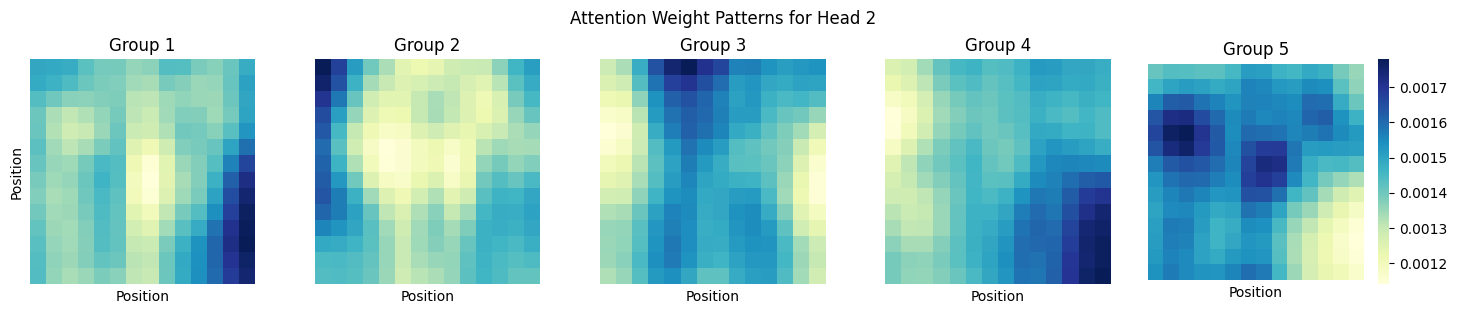

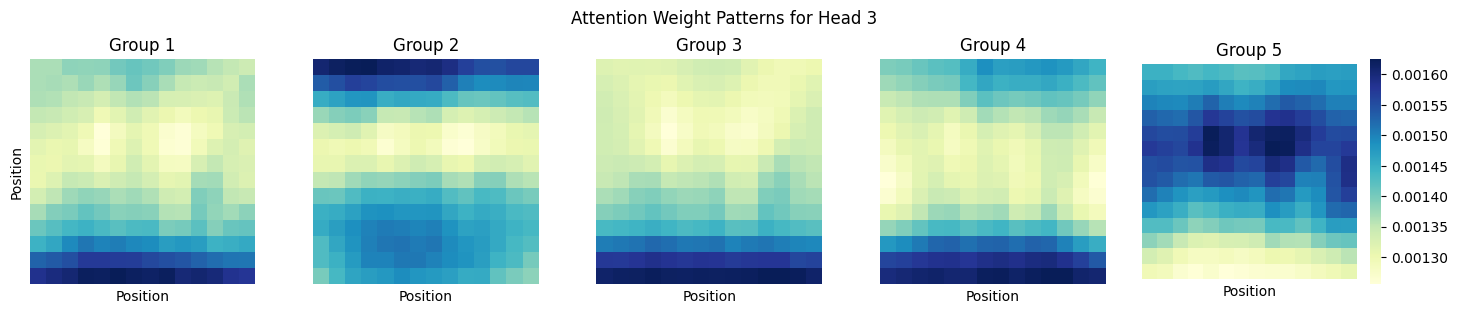

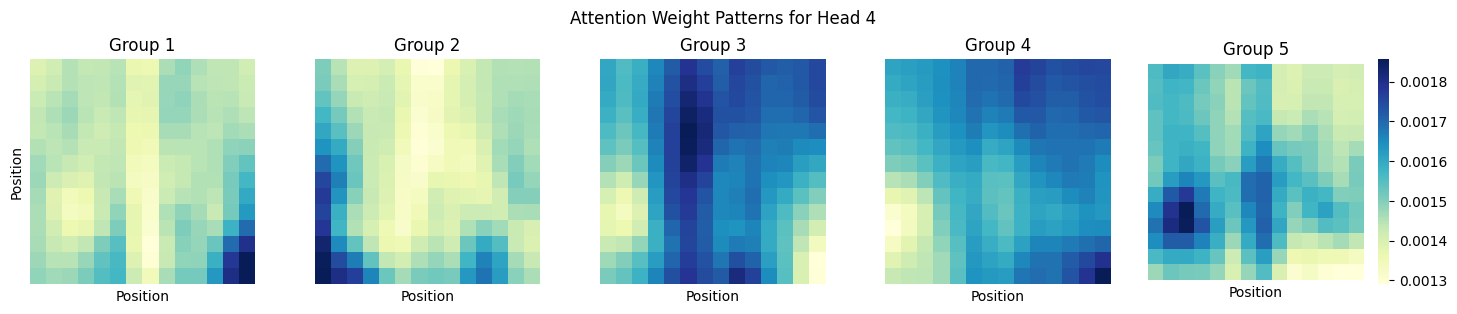

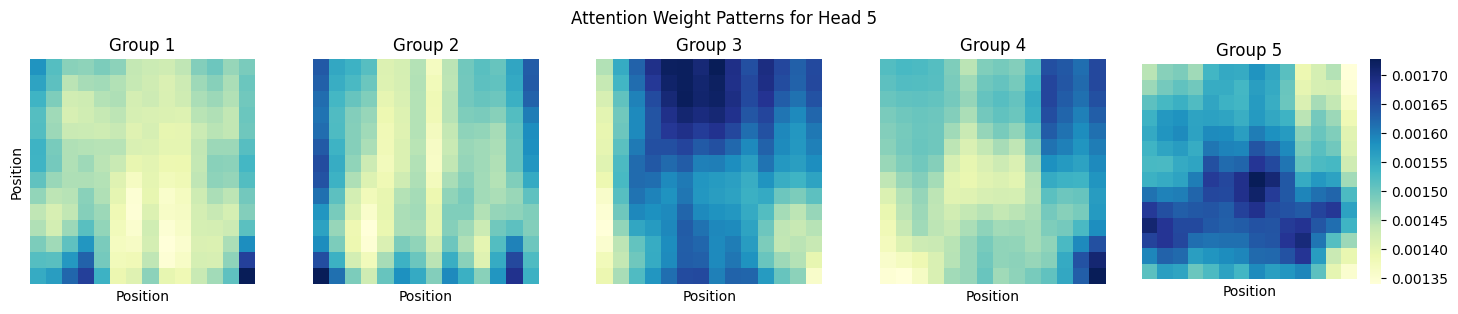

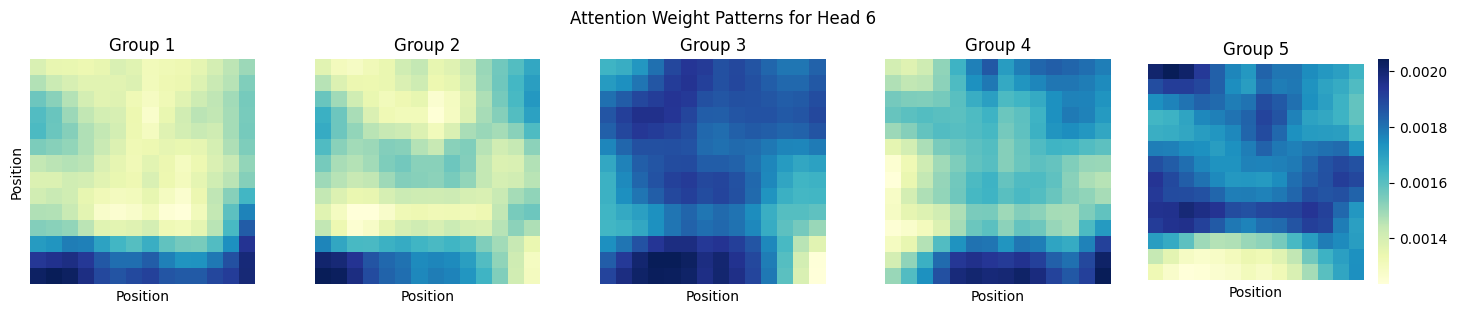

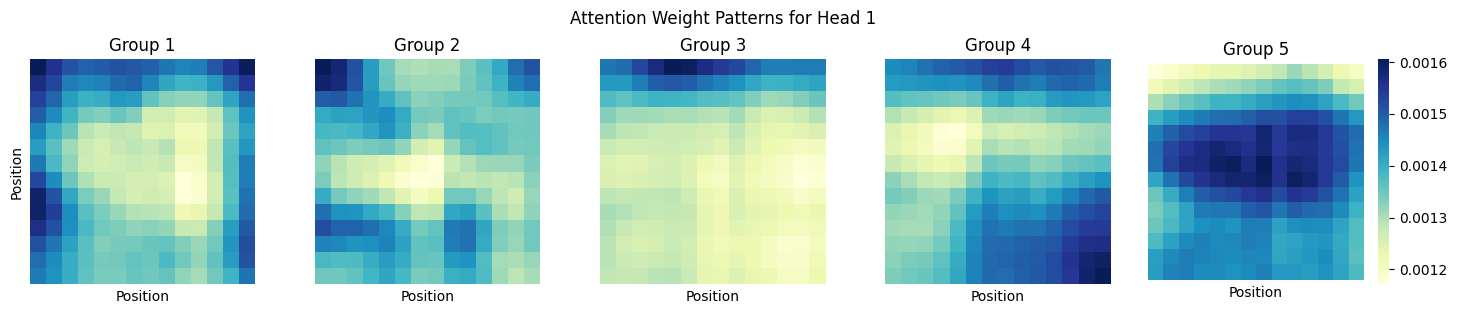

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
# Uncomment to visualize all heads
figures = visualize_all_attention_heads(_ref_enc_attn_weights, cmap='YlGnBu')
for fig in figures:
    plt.figure(fig.number)
    plt.show()

### Reference Encoder

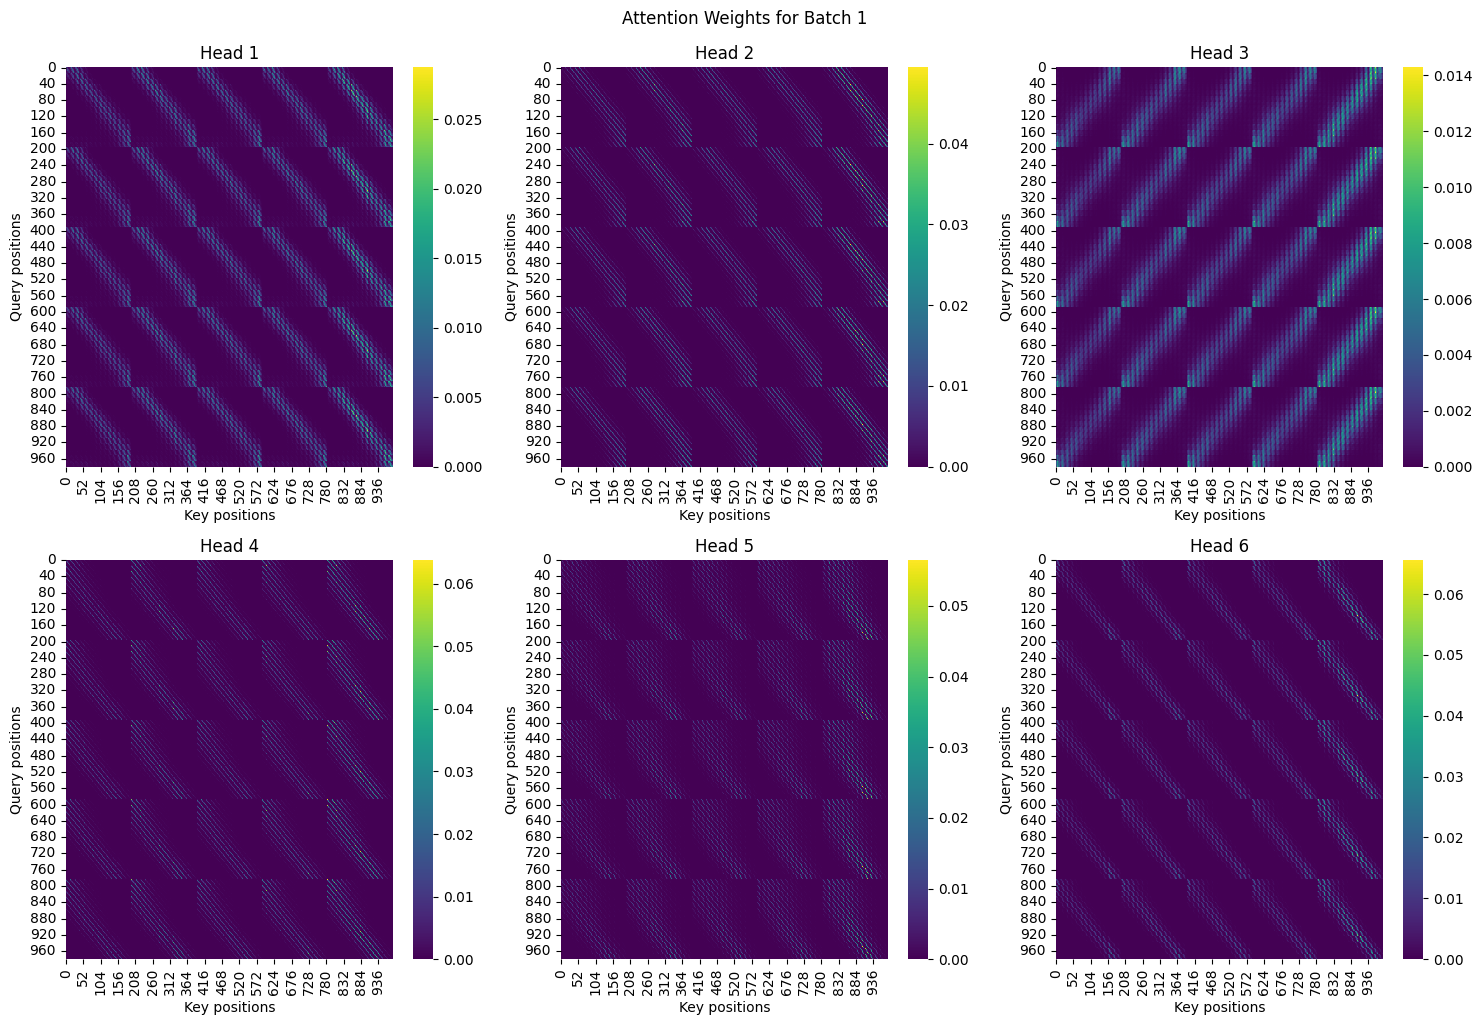

In [14]:
_ref_enc_attn_weights = _ref_enc_attn_weights.reshape(2, 6, 196 * 5, 196 * 5)   # [B, num_heads, G * L, G * L]
plot_attention_weights(_ref_enc_attn_weights, batch_idx=0, max_tokens=1000)

### Query-Ref cross-attention

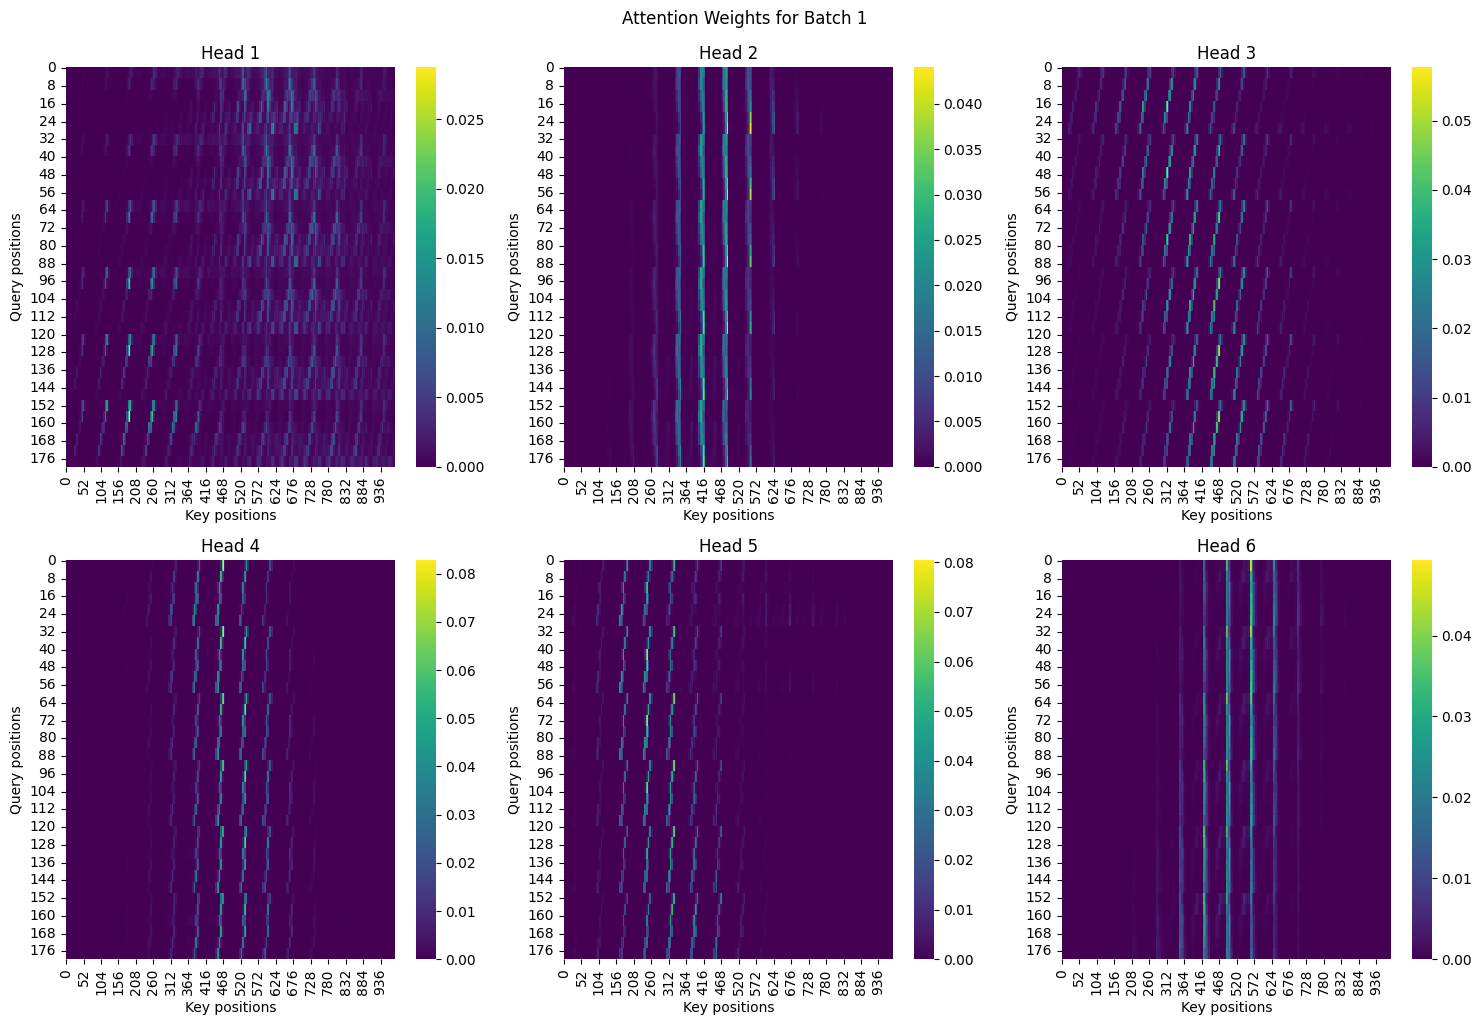

In [15]:
plot_attention_weights(query_ref_cross_attn_weights, batch_idx=0, max_tokens=1000)

## Early concatenation with early group sampling

In [16]:
checkpoint_path = '/home/admin/john/scenic/loca_56_4_early_concat_early_group_sampling_ref/checkpoint_468700'
train_state = checkpoints.restore_checkpoint(checkpoint_path, train_state)

new_rng, dropout_rng, droptok_rng, changroup_rng = jax.random.split(train_state.rng, num=4)

use_ema = True

(_, r_feat_targets, r_patch_features, _, idx_kept_groups, _), ref_state = model.flax_model.apply(
    {'params': train_state.params},
    batch['reference'],
    train=False,
    rngs={'dropout': dropout_rng, 'droptok': droptok_rng, 'changroup': changroup_rng},
    sow_weights=True,
    mutable=['intermediates']
)


n_q_foc = config.dataset_configs.number_of_focal_queries
use_pe = True if config.apply_cluster_loss else False

(q_foc_loc_pred, q_foc_feat_pred, _, _, idx_kept_groups, num_channels), query_state = model.flax_model.apply(
      {'params': train_state.params},
      batch['queries'],
      inputs_kv=jnp.tile(r_patch_features, (n_q_foc, 1, 1)),
      use_pe=use_pe,
      train=True,
      rngs={'dropout': dropout_rng, 'droptok': droptok_rng, 'changroup': changroup_rng},
      sow_weights=True,
      mutable=['intermediates'])

ref_enc_attn_weights = ref_state['intermediates']['encoderblock_11']['MultiHeadDotProductAttention_0']['attention_weights'][0]
query_ref_cross_attn_weights = query_state['intermediates']['cross_attention_block']['MultiHeadDotProductAttention_0']['attention_weights'][0]

### Reference Encoder

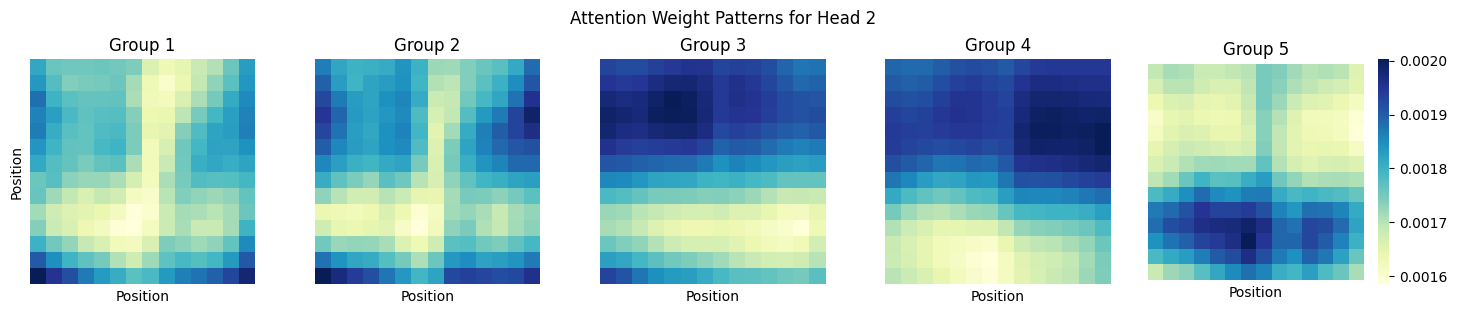

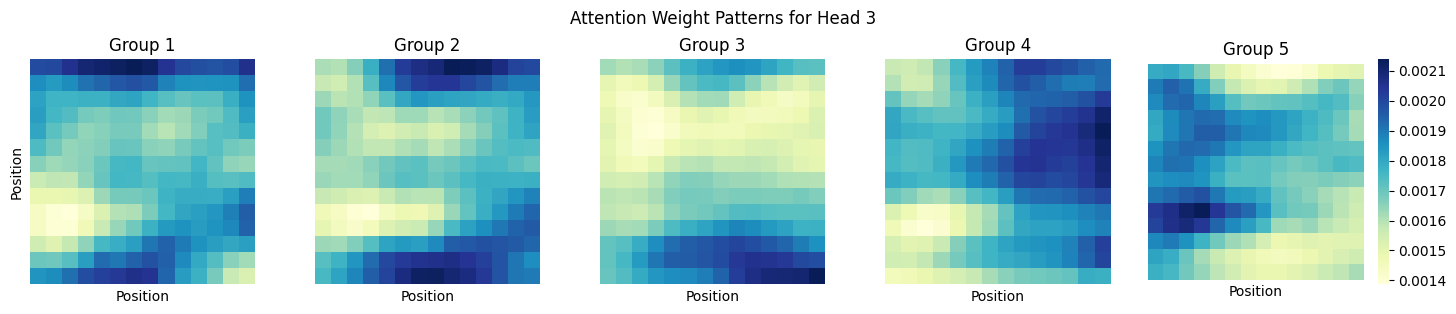

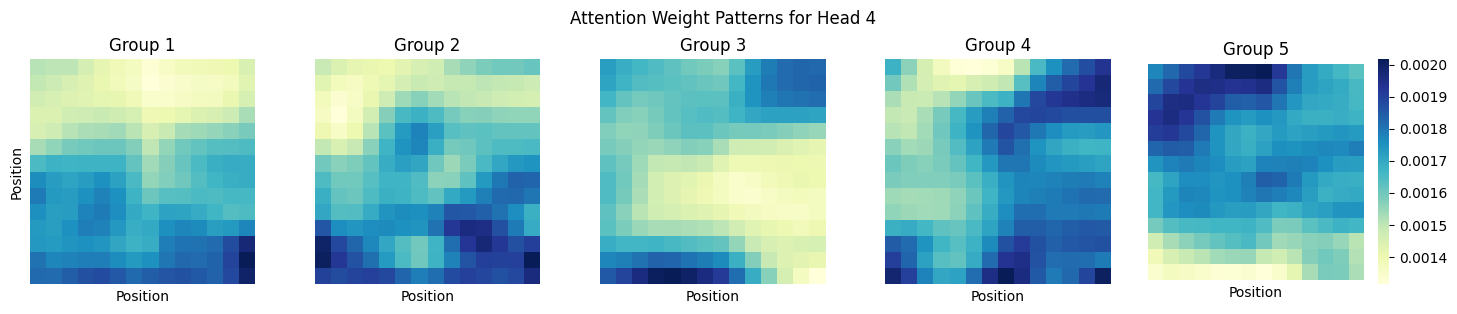

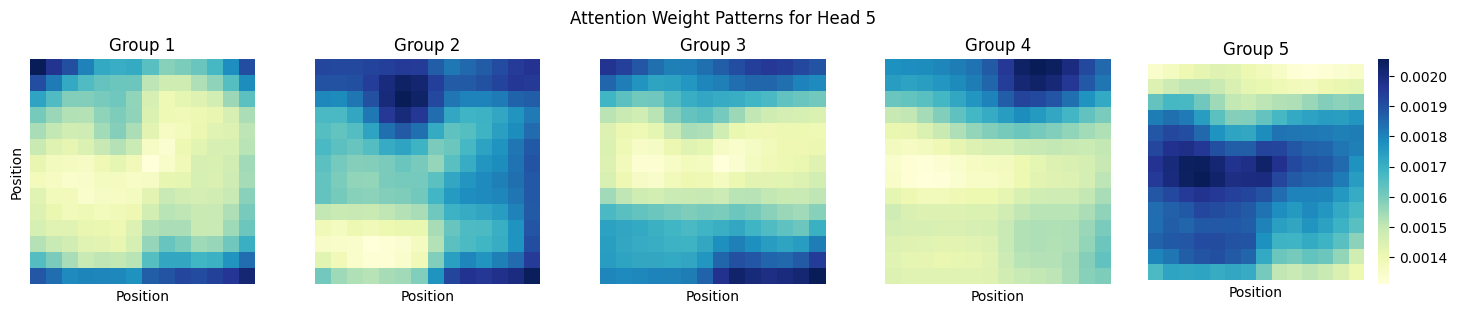

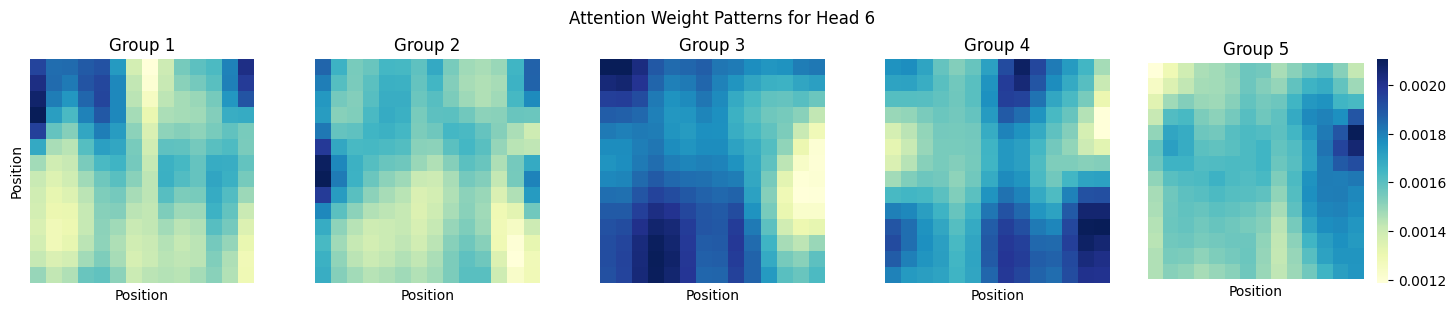

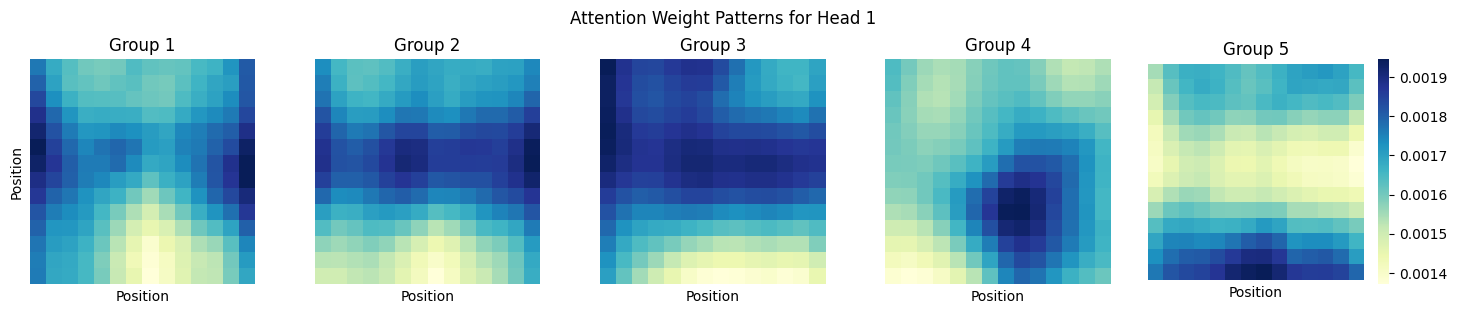

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
_ref_enc_attn_weights = ref_enc_attn_weights.reshape(2, 6, 196, 5, 196, 5)  # [B, num_heads, L, G, L, G]
_ref_enc_attn_weights = _ref_enc_attn_weights.transpose(0, 1, 3, 2, 5, 4)   # [B, num_heads, G, L, G, L]

_ref_enc_attn_weights = _ref_enc_attn_weights.reshape(2, 6, 5, 14, 14, 5, 14, 14)   # [B, num_heads, G, L, G, L]
# plt.imsave('img.png', arr=_ref_enc_attn_weights[0, 0, 0, 0, 0
_ref_enc_attn_weights.shape

figures = visualize_all_attention_heads(_ref_enc_attn_weights, cmap='YlGnBu')
for fig in figures:
    plt.figure(fig.number)
    plt.show()

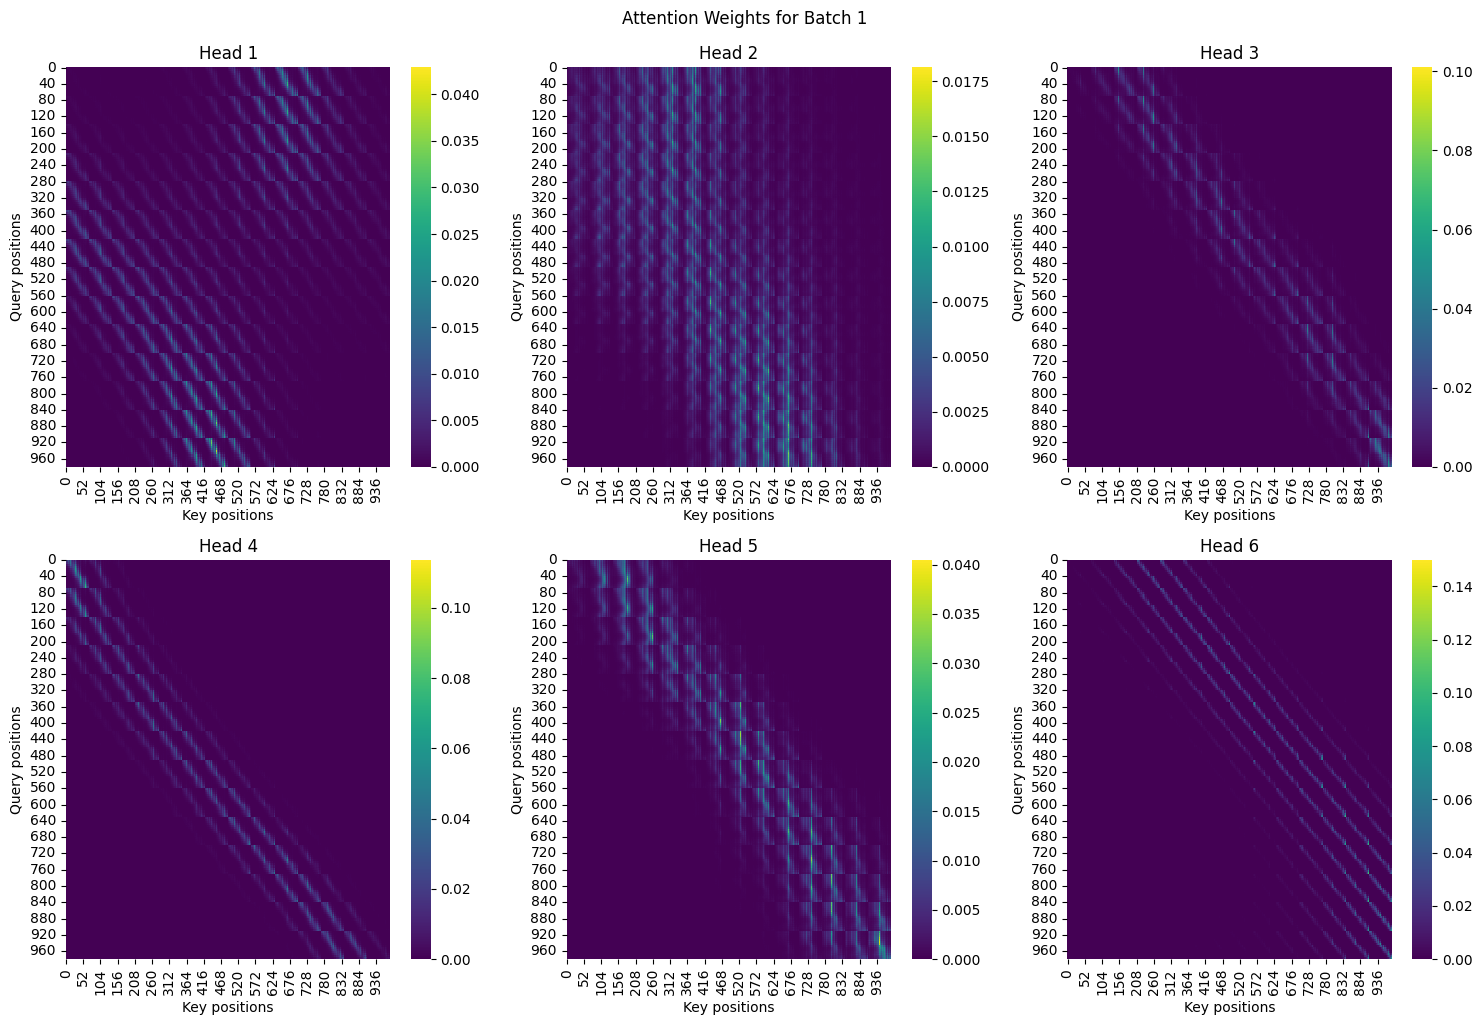

In [18]:
plot_attention_weights(ref_enc_attn_weights, batch_idx=0, max_tokens=1000)

### Query-Ref cross-attention

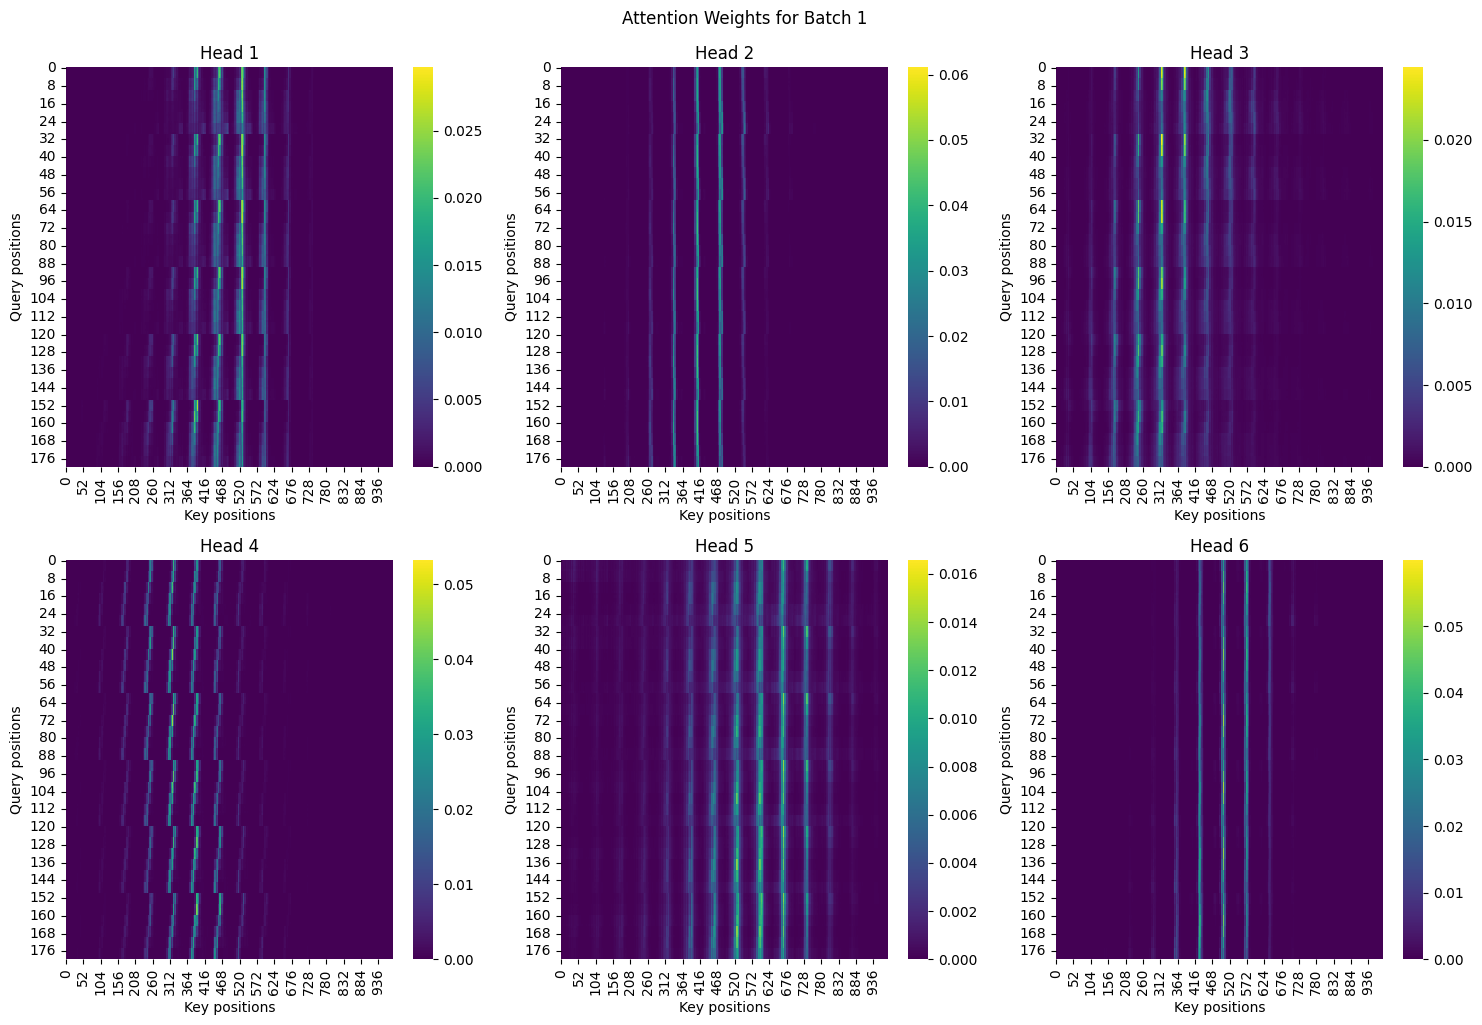

In [19]:
plot_attention_weights(query_ref_cross_attn_weights, batch_idx=0, max_tokens=1000)